In [94]:
#import pip

In [95]:
# pip.main(["install", "openpyxl"])
#pip.main(["install","scikit-learn.linear_model"])

In [96]:
import pandas as pd
from pathlib import Path
import matplotlib.pyplot as plt
import numpy as np
from sklearn.linear_model import LinearRegression
from sklearn.metrics import mean_squared_error, r2_score

In [97]:
#path = Path.cwd().joinpath("Raw_sensing_data","CO","Cu-COF-DC-8","N2_dry").rglob("*.xlsx")

#for i in path:
#    print(i)

In [98]:
def read_data(cof, gas, carrier, ppm):

    # get path to appropriate file
    path = Path.cwd().joinpath("Raw_sensing_data",gas,cof,carrier,).rglob("*.xlsx")
    #print(path)
    # some folders contain multiple excel files, so append all to a list
    files = []
    for file in path:
        files.append(file)
    print(files)
    # extract data from Excel files in list
    dfs = []
    for p in files:
        df = pd.read_excel(p,header=6,names=['time','DeltaG/G0'],usecols="B,D")
       
        df = df.dropna()
        dfs.append(df)
        
        
    return dfs
# returns pandas data frame with this data. two columns: time, DeltaG/G0

In [106]:
#print(read_data("Cu-COF-DC-8","CO","N2_dry",80))

data = read_data("Cu-COF-DC-8","H2S","air_humid",80)

[WindowsPath('c:/github things/cof-sensor-array-v2/Raw_sensing_data/H2S/Cu-COF-DC-8/air_humid/GB_S_I_188_2_Cu-COF-DC-8_H2S_80ppm_humidair.xlsx')]


In [107]:
# partition data into K sec windows in the first N sec 
# after substance introduction (750 sec)

K = 40
N = 400
n_partitions = int(N/K)

dfs = []
for i in range(n_partitions):
    dfs.append(data[0].iloc[1497+(i*K):1497+((i+1)*K)])

#print(dfs)
#print(dfs[1]['time'])

X = dfs[3].loc[:,"time"].to_numpy().reshape(-1,1)
Y = dfs[3].loc[:,"DeltaG/G0"].to_numpy().reshape(-1,1)
reg = LinearRegression().fit(X,Y)

Regression coefficients:  [[0.81385266]]
Mean squared error  0.05399230379441179


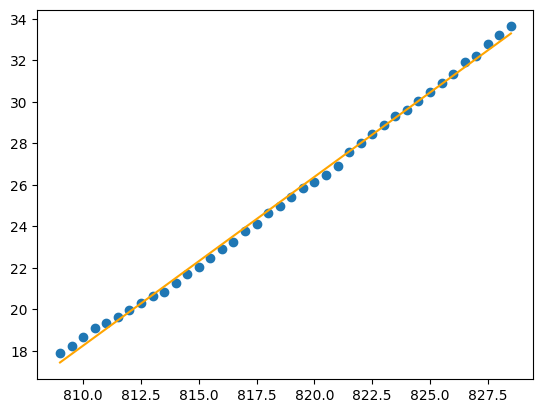

In [108]:
y_fit = reg.predict(X)


print("Regression coefficients: ",reg.coef_)
print("Mean squared error ", mean_squared_error(Y,y_fit))



plt.scatter(X,Y)
plt.plot(X,y_fit,color="orange")

plt.show()


        time  DeltaG/G0
1497   749.0  -0.054345
1498   749.5   0.000000
1499   750.0   0.000000
1500   750.5   0.000000
1501   751.0  -0.217382
...      ...        ...
3996  1998.5  91.931070
3997  1999.0  91.926729
3998  1999.5  91.951697
3999  2000.0  91.961455
4000  2000.5  91.971230

[2504 rows x 2 columns]
1497    0.032607
1498    0.043476
1499    0.043476
1500    0.043476
1501    0.000000
          ...   
1566    0.238773
1567    0.303848
1568    0.347221
1569    0.325552
1570    0.325552
Length: 74, dtype: float64
0.34722065475001884 1568
749.0 785.5


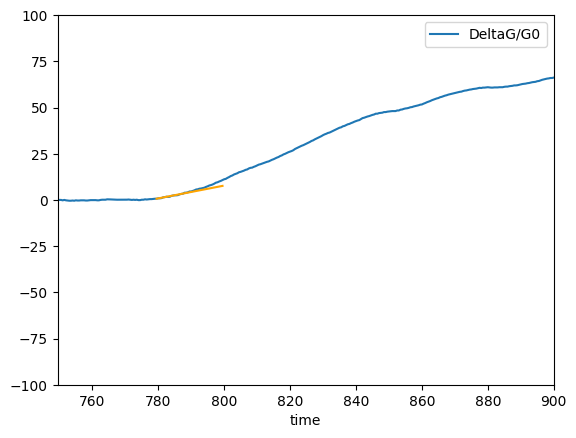

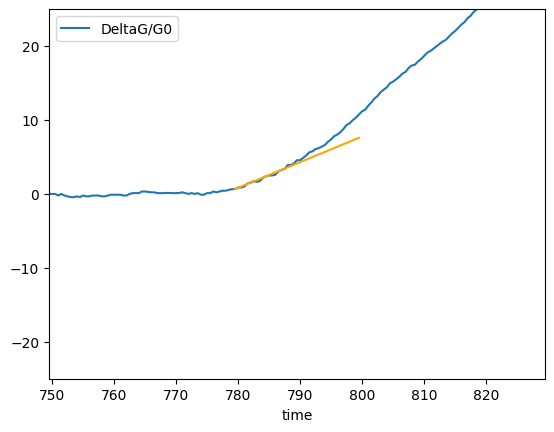

In [113]:
print(data[0].loc[1497:4000])
axes = data[0].plot(x='time',y='DeltaG/G0',xlim=(749.5,900),ylim=(-100,100))


init_t = 1497
init_t_end = 1570
per = 10
slopes = data[0].diff(periods = per).loc[init_t:init_t_end,"DeltaG/G0"] / data[0].diff(periods = per).loc[init_t:init_t_end,"time"]
#slopes = data[0].diff().loc[1400:1600,"DeltaG/G0"] / 0.5

print(slopes)
maxslope = slopes.max()
maxloc = slopes.idxmax()
print(maxslope,maxloc)
print(data[0].loc[init_t,"time"],data[0].loc[init_t_end,"time"])

x = [data[0].loc[maxloc-per,"time"],data[0].loc[maxloc+40-per,"time"]]
y = [data[0].loc[maxloc-per,"DeltaG/G0"],(x[1]-x[0])*maxslope + data[0].loc[maxloc-per,"DeltaG/G0"]]

axes.plot(x,y,'orange')

axes2 = data[0].plot(x='time',y='DeltaG/G0',xlim=(749.5,829.5),ylim=(-25,25))
axes2.plot(x,y,'orange')

In [161]:
# function to do linear regression on a single partition of data
    # input: time & DeltaG/G0 partition 
    # output: linear regression coefficient and mean squared error
def lin_reg(df):
    X = df.loc[:,"time"].to_numpy().reshape(-1,1)
    Y = df.loc[:,"DeltaG/G0"].to_numpy().reshape(-1,1)

    reg = LinearRegression().fit(X,Y)
    y_fit = reg.predict(X)
    mse = mean_squared_error(Y,y_fit)
    coef = reg.coef_.tolist().pop().pop()
    print("coef from lin_reg function: ",coef)

    return [coef,mse]

In [171]:
class SensorResponse:
    def __init__(self, cof, gas, carrier_gas, ppm):
        self.cof = cof
        self.gas = gas
        self.carrier_gas = carrier_gas
        self.ppm = ppm

        self.data = read_data(cof,gas,carrier_gas,ppm)
        
     # read in the data, do processing to get the features.
     # store data here too for viz

    # Define function to estimate initial slope of data
    # partition_size is size of the time window for partitions (ex: 30sec)
    # total_time_window is the total time after introduction of substance (750s)
    # considered to compute intial slope (ex: 300s)
    # j is which element of the self.data, default j=0
    def compute_initial_slope(self, partition_size, total_time_window,j=0):
        
        n_partitions = int(total_time_window/partition_size)
        slopes_mse = []
        partitions = []
        #partition the data
        for i in range(n_partitions):
            partitions.append(data[0].iloc[1497+(i*partition_size):1497+((i+1)*partition_size)])
        
        # perform linear regression on partitions and append (coefficient, MSE) pairs
        # to slopes_mse
        for df in partitions:
            regdata = lin_reg(df)
            # condition on mean squared error: only include data if MSE is small enough
            if regdata[1] < 0.1:
                slopes_mse.append(regdata)

        # take initial slope to be the max of the linear regression slopes which
        # satisfy the MSE condition
        #print(slopes_mse)
        slope_msedf = pd.DataFrame(slopes_mse)
        print(slope_msedf)
        initial_slope = slope_msedf[0].max()

        return initial_slope

        
'''
    def compute_initial_slope(self, nb_pts):
        initial_slopes = []
        init_t = 1497
        init_t_end = 1570
        per = 10
        for df in data:
            # initialize slopes of change in DeltaG/G0 / change in time
            # restrict to time locations between 749 seconds and 800.5 seconds
            slopes = data[0].diff(periods = per).loc[init_t:init_t_end,"DeltaG/G0"] / data[0].diff(periods = per).loc[init_t:init_t_end,"time"]

            # find maximum slope 
            maxslope = slopes.max()
            maxloc = slopes.idxmax()

            # add initial slope to list of initial slopes
            initial_slopes.append(maxslope)

        return initial_slopes '''
   #def compute_saturation(self):
   #def compute_area(self):
   #def viz(self, save=False): # viz the data along with the response features or function u fit to it.
   #def vector_representation(self): # returns the vector characterizing the response.

'\n    def compute_initial_slope(self, nb_pts):\n        initial_slopes = []\n        init_t = 1497\n        init_t_end = 1570\n        per = 10\n        for df in data:\n            # initialize slopes of change in DeltaG/G0 / change in time\n            # restrict to time locations between 749 seconds and 800.5 seconds\n            slopes = data[0].diff(periods = per).loc[init_t:init_t_end,"DeltaG/G0"] / data[0].diff(periods = per).loc[init_t:init_t_end,"time"]\n\n            # find maximum slope \n            maxslope = slopes.max()\n            maxloc = slopes.idxmax()\n\n            # add initial slope to list of initial slopes\n            initial_slopes.append(maxslope)\n\n        return initial_slopes '

In [179]:
# Test the SensorResponse class initial_slope function
test = SensorResponse("Cu-COF-DC-8","H2S","air_humid",80)


[WindowsPath('c:/github things/cof-sensor-array-v2/Raw_sensing_data/H2S/Cu-COF-DC-8/air_humid/GB_S_I_188_2_Cu-COF-DC-8_H2S_80ppm_humidair.xlsx')]


In [180]:
print(test.compute_initial_slope(40,400))

coef from lin_reg function:  0.023123657592057006
coef from lin_reg function:  0.1919786059413214
coef from lin_reg function:  0.7200555634668903
coef from lin_reg function:  0.8138526621156121
coef from lin_reg function:  0.7058842538204241
coef from lin_reg function:  0.5216036416339459
coef from lin_reg function:  0.20254640806738744
coef from lin_reg function:  0.3473994945284232
coef from lin_reg function:  0.11887600600022168
coef from lin_reg function:  0.10789433149080091
          0         1
0  0.023124  0.027916
1  0.813853  0.053992
2  0.347399  0.032910
0.8138526621156121


In [181]:
test2 = SensorResponse("Cu-COF-DC-8","NH3","air_humid",80)

[WindowsPath('c:/github things/cof-sensor-array-v2/Raw_sensing_data/NH3/Cu-COF-DC-8/air_humid/GB_S_II_3_2_Cu-COF-DC-8_NH3_80ppm_humidair.xlsx')]


In [184]:
print(test2.compute_initial_slope(40,400))

# issue, getting same initial slope for NH3 and H2S

coef from lin_reg function:  0.023123657592057006
coef from lin_reg function:  0.1919786059413214
coef from lin_reg function:  0.7200555634668903
coef from lin_reg function:  0.8138526621156121
coef from lin_reg function:  0.7058842538204241
coef from lin_reg function:  0.5216036416339459
coef from lin_reg function:  0.20254640806738744
coef from lin_reg function:  0.3473994945284232
coef from lin_reg function:  0.11887600600022168
coef from lin_reg function:  0.10789433149080091
          0         1
0  0.023124  0.027916
1  0.813853  0.053992
2  0.347399  0.032910
0.8138526621156121
